### Compute power spectra for the data

In [1]:
import sys

sys.path.insert(1, "/home/INT/lima.v/projects/phase_coupling_analysis")

In [2]:
import argparse
import os

import numpy as np
import xarray as xr
from tqdm import tqdm

from src.metrics.spectral import xr_psd_array_multitaper
from src.session import session

# from src.session import session
from src.util import _extract_roi, get_dates

###############################################################################
##### Functions
###############################################################################

###############################################################################
##### Load power files
###############################################################################

In [3]:
session_numbers = os.listdir("/home/INT/lima.v/Results/phase_encoding/psd/lucy")

In [4]:
rois = []

for session in tqdm(session_numbers):

    roi = xr.open_dataarray(
        f"/home/INT/lima.v/Results/phase_encoding/psd/lucy/{session}/sxx.nc"
    ).roi.values
    rois += [roi]

100%|█████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 771.94it/s]


In [5]:
rois = np.unique(_extract_roi(np.hstack(rois), "_")[1])

sca = ["Caudate", "Claustrum", "Thal", "Putamen"]

idx = np.logical_not([s in sca for s in rois])

rois[idx]

array(['AIP', 'Core', 'DP', 'F1', 'F2', 'F6', 'F7', 'FST', 'Ins', 'LIP',
       'MB', 'MIP', 'MST', 'MT', 'OPRO', 'PBr', 'PIP', 'SII', 'STPc',
       'TPt', 'V1', 'V2', 'V3', 'V3A', 'V4', 'V4t', 'V6A', 'VIP', 'a1',
       'a11', 'a12', 'a13', 'a14', 'a2', 'a23', 'a24D', 'a24c', 'a3',
       'a32', 'a44', 'a45A', 'a45B', 'a46D', 'a46V', 'a5', 'a7A', 'a7B',
       'a7M', 'a7op', 'a8B', 'a8L', 'a8M', 'a8r', 'a9/46D', 'a9/46V'],
      dtype='<U9')

###########################################################################
##### Load power
###########################################################################

In [6]:
sxx = []

for session in tqdm(session_numbers):

    temp = xr.open_dataarray(
        f"/home/INT/lima.v/Results/phase_encoding/psd/lucy/{session}/sxx.nc"
    )

    sxx += [temp.assign_coords({"roi": _extract_roi(temp.roi.values, "_")[1]})]

sxx = xr.concat(sxx[0], "roi")

100%|█████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 578.48it/s]


In [7]:
train_set = []

for i in range(1000):

    # Assuming 'sxx' is your xarray with dimensions (roi: 320, freqs: 32)

    # Step 1: Identify unique 'roi' values
    unique_rois = np.unique(sxx.roi.values)

    # Step 2: Sample one entry for each unique 'roi'
    sampled_indices = []
    for roi in unique_rois:
        # Get the indices where the current roi appears
        roi_indices = np.where(sxx.roi.values == roi)[0]
        # Randomly sample one index from those indices
        sampled_index = np.random.choice(roi_indices)
        sampled_indices.append(sampled_index)

    # Step 3: Use isel to select the sampled indices
    train_set += [sxx.isel(roi=sampled_indices)]

In [8]:
def gen_data(n_trials):

    train_set = []

    for i in range(n_trials):

        unique_rois = np.unique(sxx.roi.values)

        # Step 2: Sample one entry for each unique 'roi'
        sampled_indices = []
        for roi in unique_rois:
            # Get the indices where the current roi appears
            roi_indices = np.where(sxx.roi.values == roi)[0]
            # Randomly sample one index from those indices
            sampled_index = np.random.choice(roi_indices)
            sampled_indices.append(sampled_index)

        # Step 3: Use isel to select the sampled indices
        train_set += [sxx.isel(roi=sampled_indices)]

    return train_set

###########################################################################
##### RNN
###########################################################################

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

In [47]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim


class SLM(nn.Module):
    def __init__(self, n_nodes: int, g: float, f: float, h: float, eta: float):
        super().__init__()

        # Network parameters
        self.n_nodes = n_nodes

        # Node parameters
        self.a = nn.Parameter(-5 * torch.rand(n_nodes))
        self.g = g
        self.eta = nn.Parameter(eta * torch.sqrt(torch.tensor(h)))
        if isinstance(f, (int, float)):
            self.f = f * torch.ones(n_nodes)
        else:
            self.f = 60 * torch.rand(n_nodes) + 20

        self.f = nn.Parameter(2 * torch.pi * self.f)

        # Simulation parameters
        self.h = h

        # Recurrent connections
        self.W_rec = nn.Parameter(torch.rand((n_nodes, n_nodes)) * 0.1)

    def __ode(self, z: torch.Tensor, a: torch.Tensor, w: torch.Tensor):
        return z * (a + 1j * w - torch.abs(z) ** 2)

    def loop(self, z_t: torch.Tensor):
        z_t = (
            z_t
            + self.h * self.__ode(z_t, self.a, self.f)
            + self.h * self.g * (self.W_rec * (z_t[:, None] - z_t[..., None])).sum(-1)
            + self.eta * torch.randn(z_t.shape)
            + self.eta * 1j * torch.randn(z_t.shape)
        )

        return z_t

    def forward(self, n_trials: int, n_times: int, decim: int):
        rec_z_t = torch.zeros(
            n_trials, self.n_nodes, n_times // decim, dtype=torch.complex64
        )
        rec_z_t = torch.autograd.Variable(rec_z_t)

        z_t = self.h * torch.randn(n_trials, self.n_nodes) + 1j * self.h * torch.randn(
            n_trials, self.n_nodes
        )
        z_t = torch.autograd.Variable(z_t)

        record_t = 0
        for t in range(n_times):
            z_t = self.loop(z_t)
            if not t % decim:
                rec_z_t[..., record_t] = z_t
                record_t += 1

        # Compute the power spectrum (spectral power)
        # Calculate the Fourier transform of the complex-valued z_t states
        # Use `torch.fft` to perform a fast Fourier transform (FFT)
        fft_z_t = torch.fft.fft(rec_z_t, dim=-1)
        power_spectrum = (
            torch.abs(fft_z_t) ** 2
        )  # Compute the power (magnitude squared)

        # Average the power spectrum across the trials to get the final spectral power estimate
        sxx = power_spectrum.mean(0)[..., : (n_times // decim) // 2]
        freqs = torch.fft.fftfreq((n_times // decim), d=1 / 1000)[
            : (n_times // decim) // 2
        ]

        return nn.Parameter(sxx[..., freqs < 80], requires_grad=True)

In [48]:
n_nodes = 50
h = 1e-4

model = SLM(n_nodes, 0, 40, h, 1e-2)

# Loss function and optimizer
loss = torch.nn.MSELoss(reduction="mean")
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

In [49]:
freqs = torch.fft.fftfreq((4000 // 10), d=1 / 1000)[: (4000 // 10) // 2]

In [50]:
model.forward(30, 4000, 10).shape

torch.Size([50, 32])

In [51]:
epochs = 10
# Training loop
best_eval = 0.0
for epoch in tqdm(range(epochs)):
    tqdm.write(f"epoch {epoch}")
    train_set = xr.concat(gen_data(50), "trials").sel(roi="F1")  # Assuming gen_data generates a batch of data
    # Loop over batches for one epoch

    model.train()

    # Zero gradients
    optimizer.zero_grad()

    # Predict: Assuming output has shape (batch_size, n_rois, n_time_steps)
    output = model.forward(1, 4000, 10)

    # Normalize the output (make sure you're normalizing the correct dimension)
    output = output / output.max(0).values[None, :]
    sxx_ = train_set / train_set.max("freqs")

    # Initialize the total loss
    total_loss = 0.0

    # Compute the loss for this specific ROI
    total_loss = loss(output, torch.as_tensor(sxx_.values, dtype=torch.float32))
    


    # Compute gradients (this will propagate gradients for each ROI individually)
    total_loss.backward()

        # Print the total loss for debugging
    tqdm.write(f"epoch {epoch}; total_loss {total_loss.item()}")

    
    # Update parameters
    optimizer.step()

    # Print output values for debugging
    print(f"Epoch {epoch}, Output mean: {output.mean().item()}, Output max: {output.max().item()}")


  0%|                                                                   | 0/10 [00:00<?, ?it/s]

epoch 0


 10%|█████▉                                                     | 1/10 [00:00<00:02,  3.54it/s]

epoch 0; total_loss 0.09724903106689453
Epoch 0, Output mean: 0.18530580401420593, Output max: 1.0
epoch 1


 20%|███████████▊                                               | 2/10 [00:00<00:02,  3.54it/s]

epoch 1; total_loss 0.10864243656396866
Epoch 1, Output mean: 0.21831580996513367, Output max: 1.0
epoch 2


 30%|█████████████████▋                                         | 3/10 [00:00<00:01,  3.57it/s]

epoch 2; total_loss 0.09711252152919769
Epoch 2, Output mean: 0.21381734311580658, Output max: 1.0
epoch 3


 40%|███████████████████████▌                                   | 4/10 [00:01<00:01,  3.58it/s]

epoch 3; total_loss 0.10677137225866318
Epoch 3, Output mean: 0.2153027355670929, Output max: 1.0
epoch 4


 50%|█████████████████████████████▌                             | 5/10 [00:01<00:01,  3.58it/s]

epoch 4; total_loss 0.10273801535367966
Epoch 4, Output mean: 0.2227768748998642, Output max: 1.0
epoch 5


 60%|███████████████████████████████████▍                       | 6/10 [00:01<00:01,  3.27it/s]

epoch 5; total_loss 0.06789802759885788
Epoch 5, Output mean: 0.13895586133003235, Output max: 1.0
epoch 6


 70%|█████████████████████████████████████████▎                 | 7/10 [00:02<00:00,  3.37it/s]

epoch 6; total_loss 0.095269575715065
Epoch 6, Output mean: 0.21849550306797028, Output max: 1.0
epoch 7


 80%|███████████████████████████████████████████████▏           | 8/10 [00:02<00:00,  3.44it/s]

epoch 7; total_loss 0.09465133398771286
Epoch 7, Output mean: 0.18373419344425201, Output max: 1.0
epoch 8


 90%|█████████████████████████████████████████████████████      | 9/10 [00:02<00:00,  3.48it/s]

epoch 8; total_loss 0.11328687518835068
Epoch 8, Output mean: 0.24392536282539368, Output max: 1.0
epoch 9


100%|██████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.49it/s]

epoch 9; total_loss 0.09866725653409958
Epoch 9, Output mean: 0.21681682765483856, Output max: 1.0


In [52]:
model.eval()

SLM()

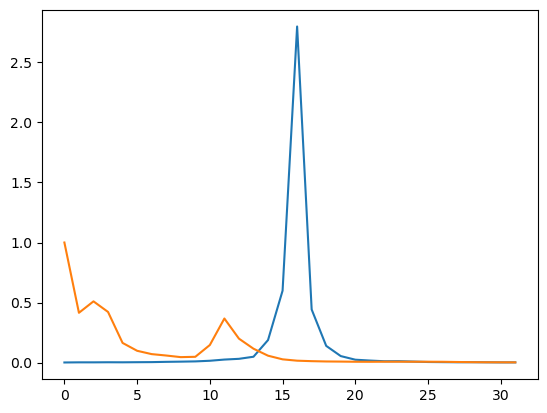

In [56]:
plt.plot(model(30, 4000, 10)[2].detach().numpy())
plt.plot(sxx_[2])

In [215]:
for param in model.parameters():
    print(f"{param}: Param requires_grad: {param.requires_grad}")

Parameter containing:
tensor([-3.9045, -3.8138, -2.6786, -3.7757, -4.6927, -4.1631, -4.5198, -3.6183,
        -2.8963, -0.6824, -0.7198, -0.1798, -0.3366, -3.5729, -1.6614, -0.5952,
        -1.7093, -2.5082, -0.2880, -4.3184, -4.8540, -0.9450, -0.9655, -1.3325,
        -0.6331, -0.2389, -4.9401, -1.7016, -0.6107], requires_grad=True): Param requires_grad: True
Parameter containing:
tensor(1., requires_grad=True): Param requires_grad: True
Parameter containing:
tensor([251.3274, 251.3274, 251.3274, 251.3274, 251.3274, 251.3274, 251.3274,
        251.3274, 251.3274, 251.3274, 251.3274, 251.3274, 251.3274, 251.3274,
        251.3274, 251.3274, 251.3274, 251.3274, 251.3274, 251.3274, 251.3274,
        251.3274, 251.3274, 251.3274, 251.3274, 251.3274, 251.3274, 251.3274,
        251.3274], requires_grad=True): Param requires_grad: True
Parameter containing:
tensor([[1.6687e-02, 2.9934e-02, 9.7957e-02, 3.4050e-02, 6.4241e-02, 2.6003e-02,
         7.8092e-02, 9.8401e-02, 8.4151e-02, 3.0603e-0

In [209]:
sxx_ = sxx_ / sxx_.max("freqs")

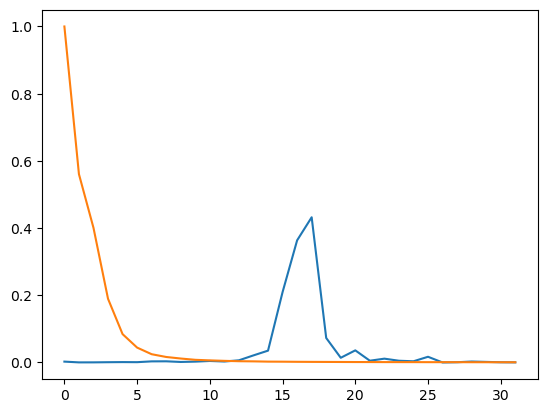

In [210]:
plt.plot(output.detach().numpy()[0])
plt.plot(sxx_[0])

In [211]:
for param in model.parameters():
    if param.grad is not None:
        print(f"Gradient for {param}: {param.grad.mean().item()}")

In [189]:
torch.nn.MSELoss(reduction="sum")(
    output, torch.as_tensor(sxx_.values, dtype=torch.float32)
)

tensor(124.2411, grad_fn=<MseLossBackward0>)

In [151]:
out = model(1, 4000, 10)

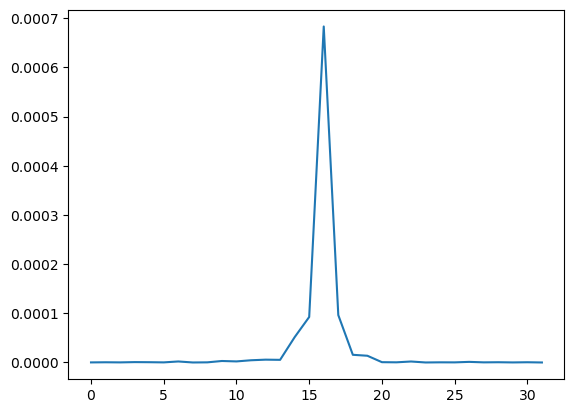

In [157]:
plt.plot(out[3].detach().numpy())